# Natural Language Processing Project
#### By: Lupe Luna, Forrest McCrosky, and Anna Vu
---

We will be using web scraping to extract some of the most-starred repositories on Github, and build a multi-classification model to predict what the most predominant programming language used will be based off of the README.md contents. 

[View this journal in jupyter nbviewer](https://nbviewer.jupyter.org/github/Vu-Luna-McCrosky-NLP-Project/NLP_Project_Predicting_Readme_s/blob/master/final_nlp.ipynb)

<br>

# Agenda:
---
- [Executive Summary](#executive_summary)
 - [Project Planning](#project_planning)
 - [Imports](#imports)
 - [Data Acquisition](#data_acquisition)
 - [Data Preparation](#data_preparation)
 - [Data Exploration](#data_exploration)
 - [Statistical Testing](#stats)
 - [Modeling](#modeling)
 - [Test](#test)
 - [Conclusion and Next Steps](#conclusion)

<br>

<a id='executive_summary'></a>
# Executive Summary:
---
To predict the most used programming language for each repository, we used a KNN model (fit with TD-IDF vectorizer) to predict with:
 - 82% accuracy
 - 82% precision
 - 76% recall
 
based off of the README's contents on out of sample data.

Our model does better predicting the result of a repository if its programming language is JavaScript or Python. For next time, we could probably use a bigger sample of repositories to help it account for Java, Go, and other languages.

<a id='project_planning'></a>
# Project Planning:
---
We're going to need to use web scraping in order to get ~200 repositories from [Github](www.github.com), once we bring in these in, we will filter for desirable README contents (language, size, etc.) We need to use the content of at least 100 READMEs, so to best ensure they will have valuable information, we are going to scrape our data from the [most starred repositories](https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories) on Github. 

After we follow the steps of the data science pipeline, we'll need to set up a couple of slides to present our findings.

<br>

<a id='imports'></a>
# Imports:

In [1]:
#import our modules
import acquire as a
import prepare as p
import explore as e
import model as m

#import our most-used libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

#import NLP neccessities
import nltk
import re
from pprint import pprint
import unicodedata
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
import bs4
import time

#import sklearn for our models
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

<a id='data_acquisition'></a>
# Data Acquisition: 
---

In [2]:
## use acquire function that built a repo list from github.com's most starred repositories

repos = a.get_repo_list() 

In [3]:
print(f'The length of the repo list is: {len(repos)}\n') ## <-- quality assurance check

repos[:6] ## looking at some readme titles

The length of the repo list is: 210



['\n      Showing 11,515,575 available\n      repository results\n    ',
 'freeCodeCamp/freeCodeCamp',
 '996icu/996.ICU',
 'EbookFoundation/free-programming-books',
 'jwasham/coding-interview-university',
 'vuejs/vue']

### Intial Repo List Function
 
 - get_repo_list() is designed to create a repo list from the most starred repositories on Github.
    
 - The function loops through 20 pages with 10 results per page of the most starred repos on github using a range from 1 to 21.
    
 - It then uses another loop to pull out all the titles of each repo using the beautiful soup library and html per page. It will also remove null elements and white spaces.
    
 - After get_repo list ran, we manually removed 6 repositories from the list that were poorly formatted and not repository titles. 
 - This leaves us 198 repos.
    
    
 - Since it does take a while to run and grab 200 repositiories (and you'll need your own Github token to have it function properly), we decided to create a .csv as an endproduct for our usage.

<br>

Ran acquire.py from the terminal, and brought in our .json file as a dataframe

In [4]:
## reading our json file built from the acquire.py into a df

df = pd.read_json('data2.json') 

<br>
Now we are going to filter for the top four languages. We found them to be JavaScript, Python, Java, and Go.

In [5]:
## making a list of the top four used programming languages

top_four = df.language.value_counts().keys()[0:4] 

In [6]:
## filtering down dataframe to contain top four langauges

df = df[df.language.isin(top_four)] 

In [7]:
df.head() ## <-- quality assurance check

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
4,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
5,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
9,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
10,public-apis/public-apis,Python,# Public APIs [![Run tests](https://github.com...


<br>
Create a .csv, from the steps above, to be able to bring up this data faster as we work through the project.

In [8]:
df.to_csv('NLP_df.csv')

<br>
Let's bring in the data with NLP_df.csv

In [9]:
#bring in NLP_df.csv as a pandas dataframe
df = a.get_github_data()

#look at our dataframe
df

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
2,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
4,public-apis/public-apis,Python,# Public APIs [![Run tests](https://github.com...
...,...,...,...
107,gogs/gogs,Go,"# <img src=""https://github.com/gogs/gogs/raw/m..."
108,nuxt/nuxt.js,JavaScript,"<p align=""center""><img align=""center"" style=""w..."
109,iptv-org/iptv,JavaScript,# IPTV\n\n![auto-update](https://github.com/ip...
110,mermaid-js/mermaid,JavaScript,# mermaid [![Build Status](https://travis-ci.o...


### Acquisition Takeaways:

 - New features could be made, like character count and word count. 
 - Notice non-English characters in the contents
 - Need to clean the readme_contents
 - Duplicates were dropped while bringing in the data
 - We went from 200 to 109 rows

<a id='data_preparation'></a>
# Data Preparation:
---

In [10]:
#this prep function will clean our readme_contents, and create readme_length and word_count features
df = p.prep_github_data(df, 'readme_contents')

In [11]:
#check the results of the prep function
df.head()

,repo,language,readme_contents,original,clean,stemmed,lemmatized,readme_length,word_count
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,15352,764
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...","<p align=""center""><a href=""https://vuejs.org"" ...",p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...,15072,861
2,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,# [React](https://reactjs.org/) &middot; [![Gi...,reacthttpsreactjsorg middot github licensehttp...,reacthttpsreactjsorg middot github licensehttp...,reacthttpsreactjsorg middot github licensehttp...,3656,322
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...","<p align=""center"">\n <a href=""https://getboot...",p aligncenter hrefhttpsgetbootstrapcom img src...,p aligncent hrefhttpsgetbootstrapcom img srcht...,p aligncenter hrefhttpsgetbootstrapcom img src...,9882,606
4,public-apis/public-apis,Python,# Public APIs [![Run tests](https://github.com...,# Public APIs [![Run tests](https://github.com...,public apis run testshttpsgithubcompublicapisp...,public api run testshttpsgithubcompublicapispu...,public apis run testshttpsgithubcompublicapisp...,82956,8170


In [12]:
#checking target variables distribution
df.language.value_counts()

JavaScript    55
Python        24
Java          15
Go            13
Name: language, dtype: int64

In [13]:
#split our data into train, validate, and test sets
train, validate, test = p.split(df)

In [14]:
#assure the shapes are reasonable
train.shape, validate.shape, test.shape

((59, 9), (26, 9), (22, 9))

In [15]:
#checking the balance of our train target variables
train.language.value_counts()

JavaScript    31
Python        13
Java           8
Go             7
Name: language, dtype: int64

### Preparation Takeaways: 
 - We have a clean set of readme_contents that we can explore on
 - Any READMEs with less than 10 words were dropped
 - Proceed to explore on our train set
 - We need to categorize content based on its dominant programming language, so we can find what words can help our model decifer what language is being used the most

<a id='data_exploration'></a>
# Data Exploration
---

We are going to separate the clean README contents based on its repository's dominant programming language, and also have an inclusive one. We're only going to be exploring on our train dataset. 

In [16]:
#content and its words put under the repository's primary language
javascript_words = ' '.join(train[train.language == 'JavaScript'].clean)
python_words = ' '.join(train[train.language == 'Python'].clean)
java_words = ' '.join(train[train.language == 'Java'].clean)
go_words = ' '.join(train[train.language == 'Go'].clean)
all_words = ' '.join(train.clean)

Now we're going to split the content into individual words by splitting them based on spaces, and take a value counts to see how often each word comes up for each programming language. (Also did a frequency count for all words)

In [17]:
#split up content into indivdual words, and count how many times the word comes up over all readmes
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

Now we will combine all of the frequencies, so we can view the words and how often they are used across the four languages.

In [18]:
#create a df of frequencies of each word by language 
word_counts = pd.concat([javascript_freq, python_freq, java_freq, go_freq, all_freq], axis=1).fillna(0).astype(int)

#name the columns
word_counts.columns = ['javascript', 'python','java','go','all']

#check our most frequently occuring words
word_counts.sort_values('all', ascending=False).head(10)

,javascript,python,java,go,all
source,928,56,7,16,1007
javascript,782,41,0,0,823
python,162,547,0,0,709
data,154,320,7,1,482
use,226,189,16,16,447
learning,33,410,1,0,444
icon,430,0,0,0,430
library,39,374,5,1,419
freewarefreeware,395,0,0,0,395
1,215,135,37,2,389


In [19]:
# Sorting By Java and JavaScript both in descending order to look for overlap
word_counts.sort_values(['java', 'javascript'], ascending=[False, False]).head(8)

,javascript,python,java,go,all
td,107,0,174,0,281
aligncentera,1,0,172,0,173
width100px,0,0,172,0,172
altbr,0,0,172,0,172
titlecodeatd,0,0,127,0,127
tr,27,2,88,0,117
java,66,24,41,0,131
1,215,135,37,2,389


In [20]:
# Sorting By Python and Go
word_counts.sort_values(['python', 'go'], ascending=[False, False]).head(8)

,javascript,python,java,go,all
python,162,547,0,0,709
learning,33,410,1,0,444
library,39,374,5,1,419
machine,17,339,0,1,357
data,154,320,7,1,482
http,38,232,2,1,273
use,226,189,16,16,447
video,31,169,0,0,200


In [21]:
# Sorting By Python and Java
word_counts.sort_values(['python', 'java'], ascending=[False, False]).head(8)

,javascript,python,java,go,all
python,162,547,0,0,709
learning,33,410,1,0,444
library,39,374,5,1,419
machine,17,339,0,1,357
data,154,320,7,1,482
http,38,232,2,1,273
use,226,189,16,16,447
video,31,169,0,0,200


In [22]:
#there are 25,631 different 'words' in our train dataset
word_counts

,javascript,python,java,go,all
source,928,56,7,16,1007
javascript,782,41,0,0,823
icon,430,0,0,0,430
freewarefreeware,395,0,0,0,395
const,388,0,0,0,388
...,...,...,...,...,...
imagehttpsgolangorgdocgopherfiveyearsjpg,0,0,0,1,1
millisecond,0,0,0,1,1
httpsgolangorgwikiquestions,0,0,0,1,1
githubcomdanwakefieldfnmatchv00020160403171240cbb64ac3d964,0,0,0,1,1


Let's compare programming languages and how much they use any of the overall top 20 words across all READMEs

#### Most Frequent Words 

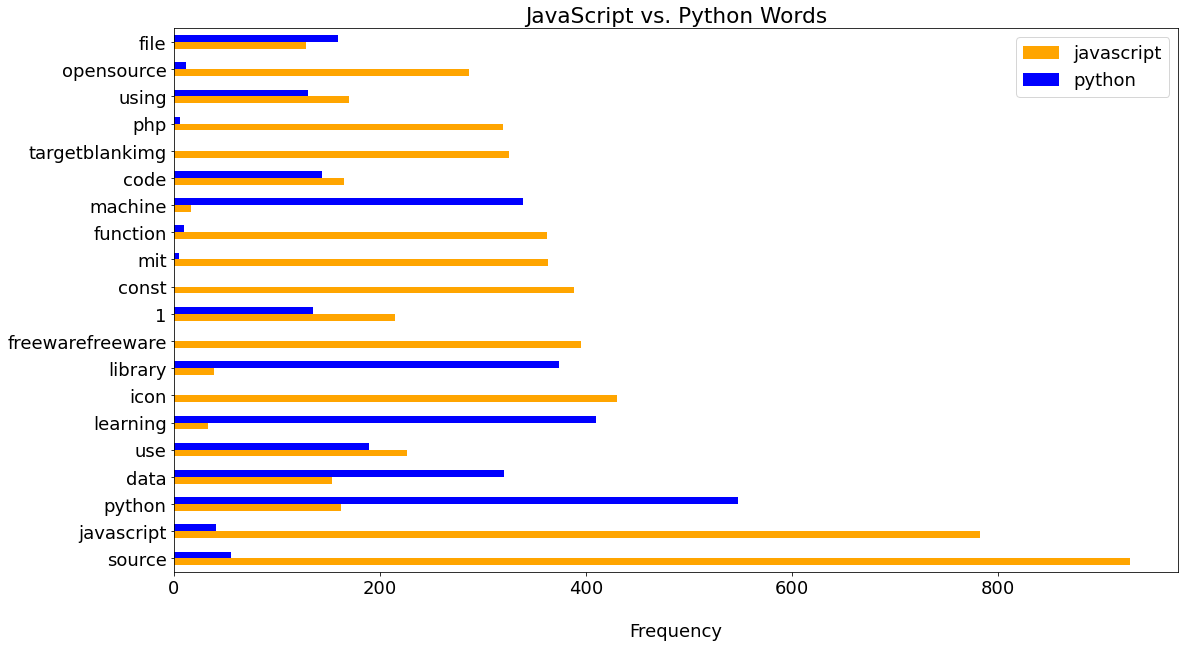

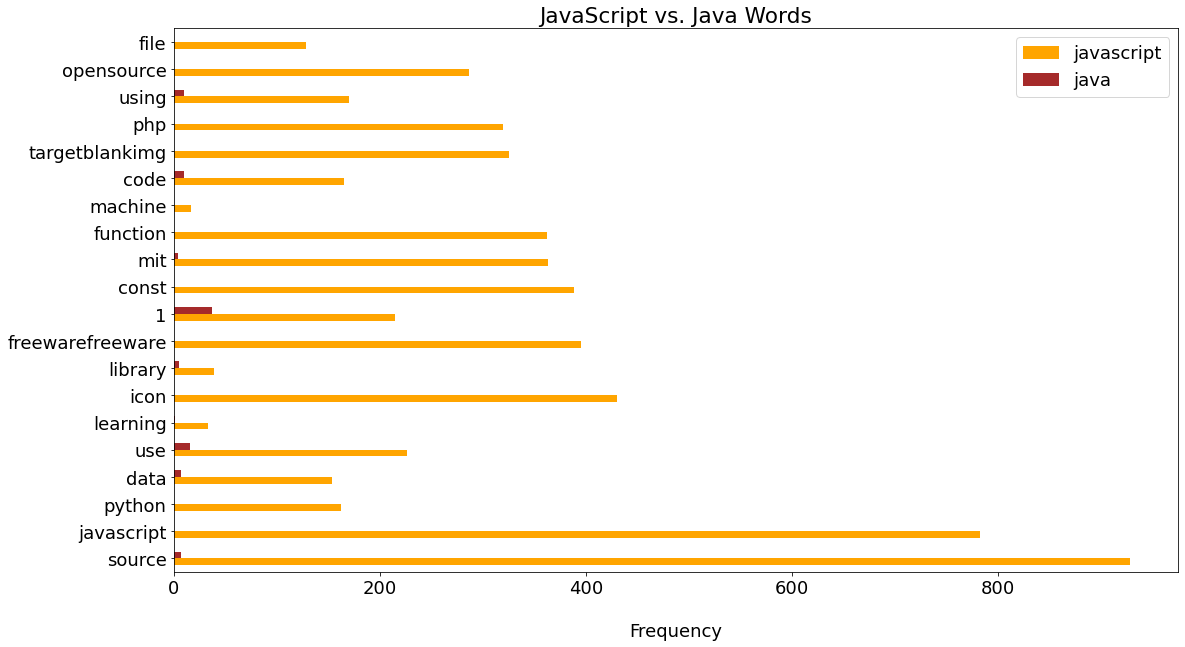

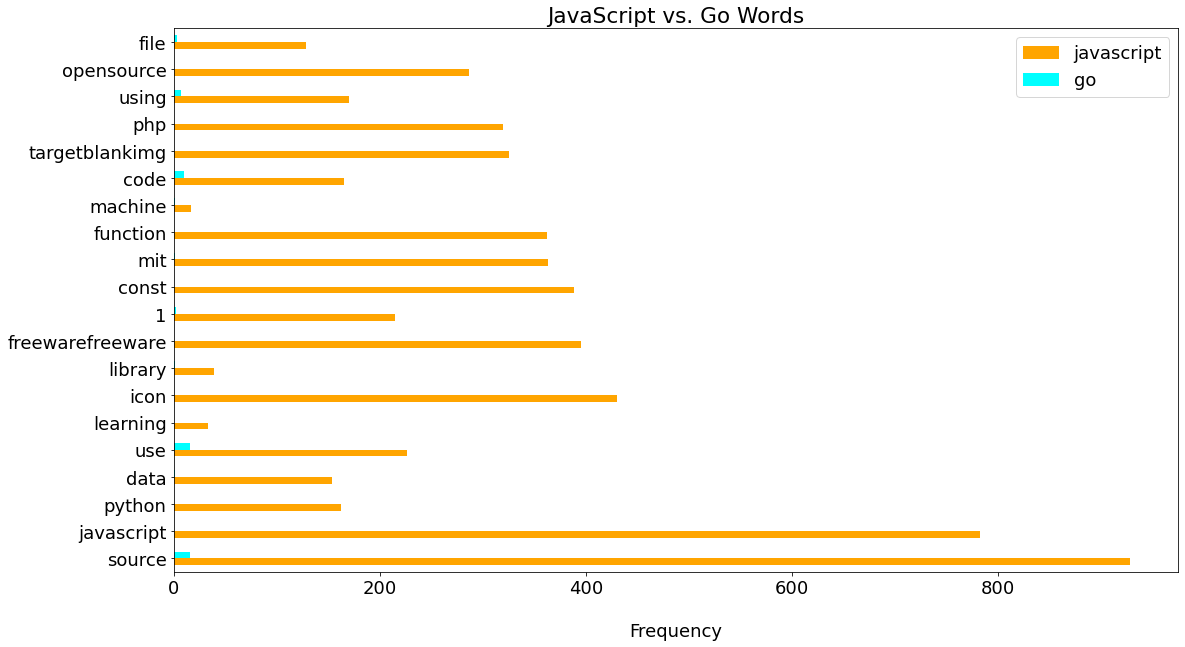

In [23]:
e.javascript_barh(word_counts)

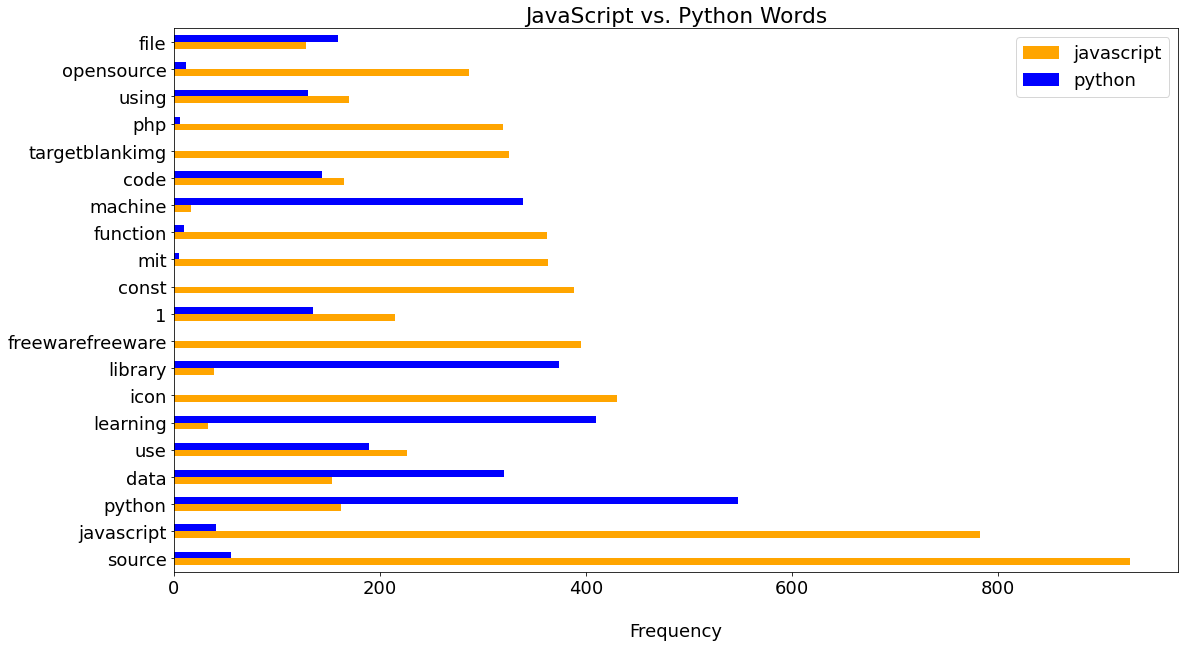

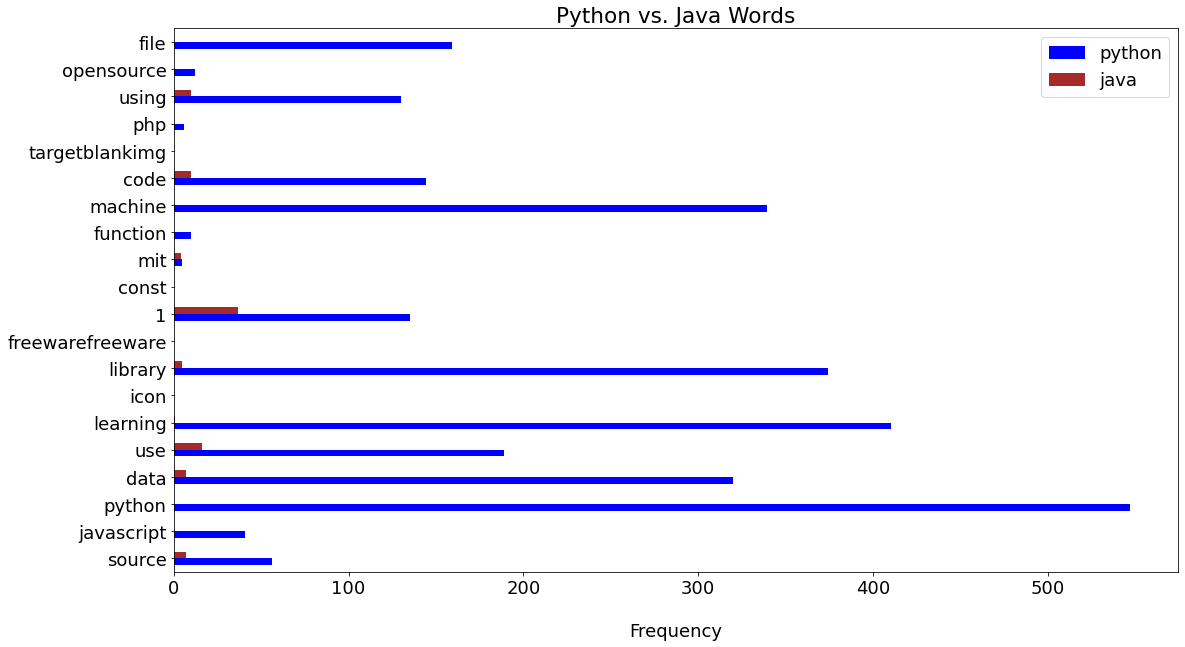

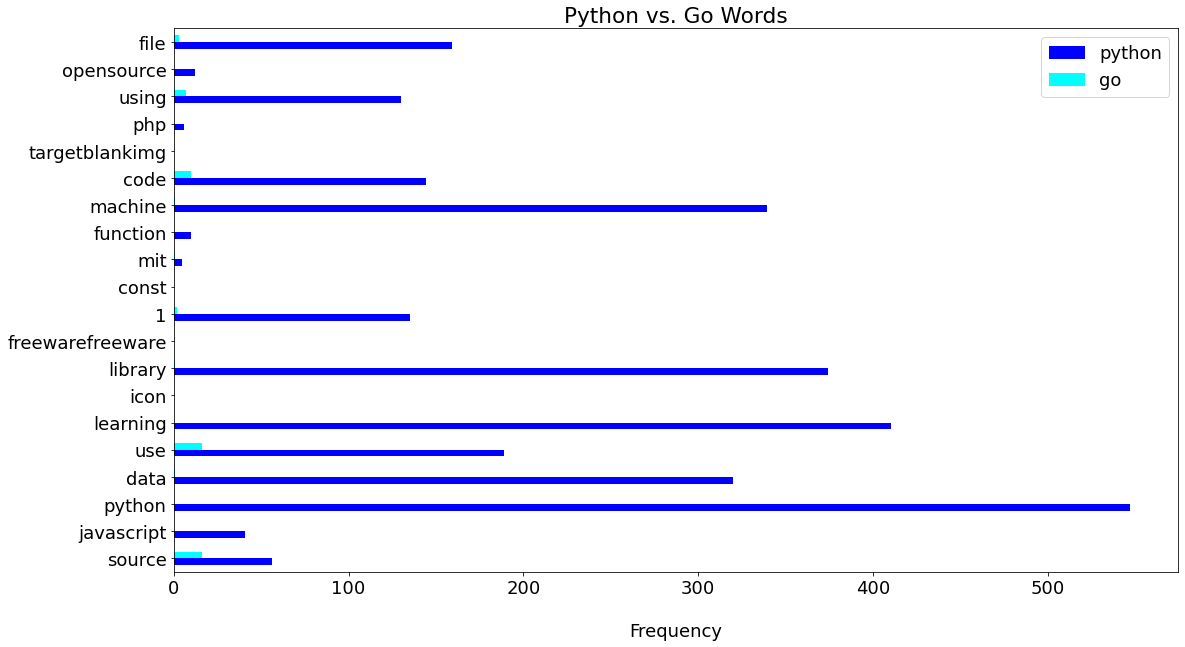

In [24]:
e.python_barh(word_counts)

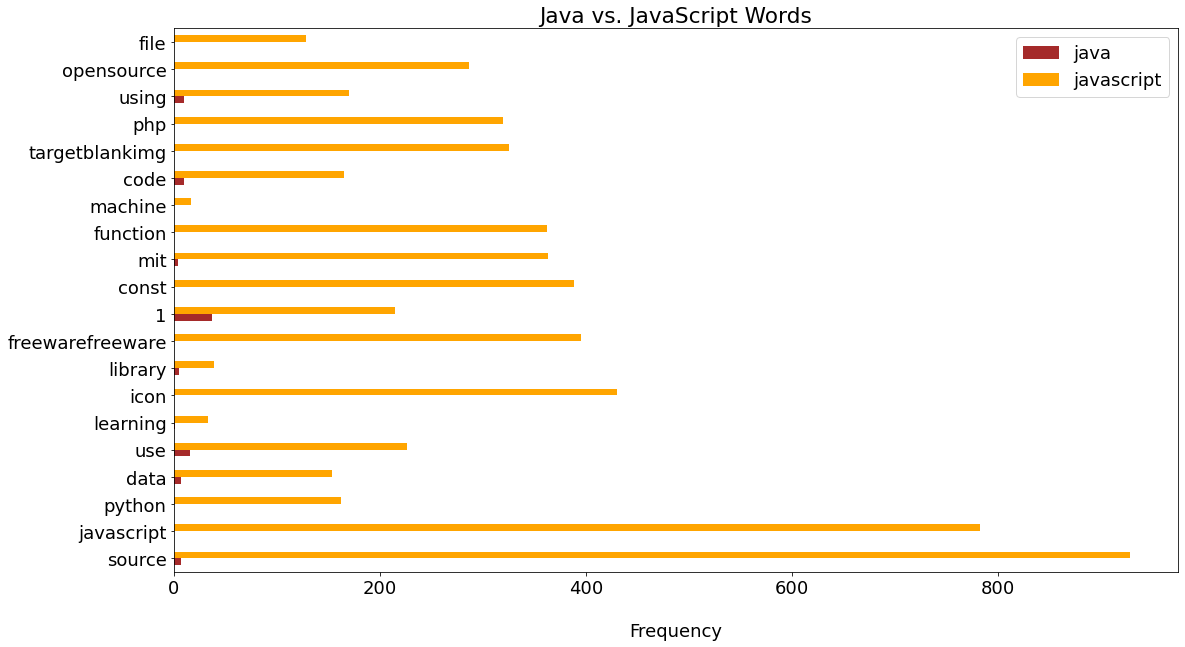

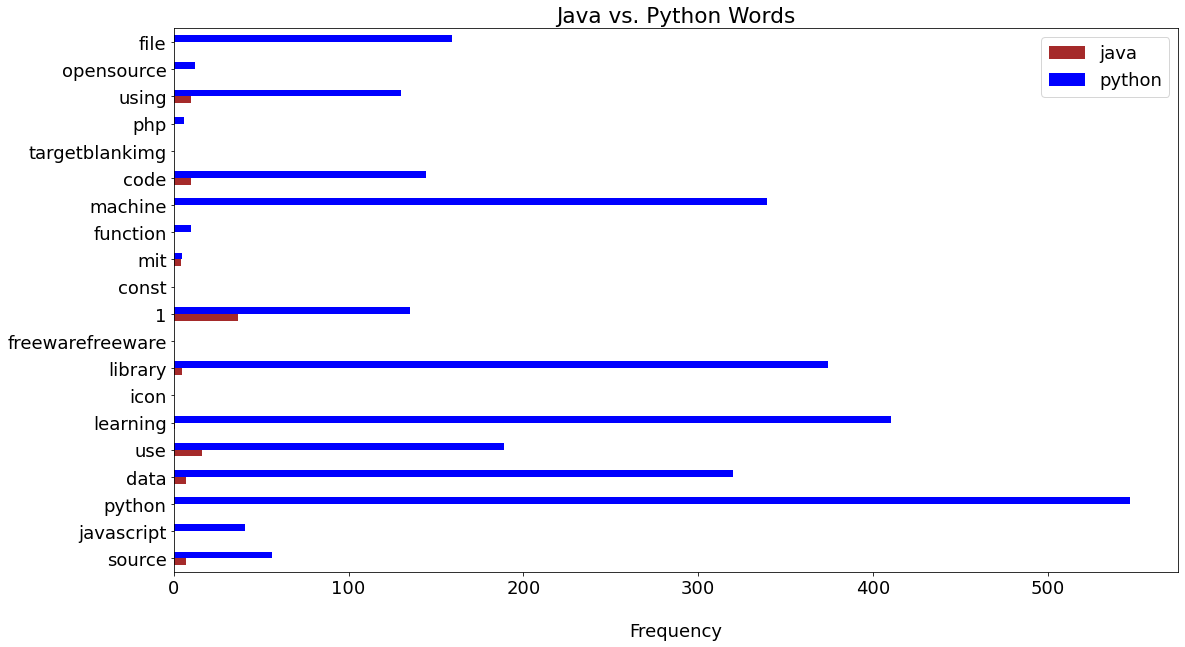

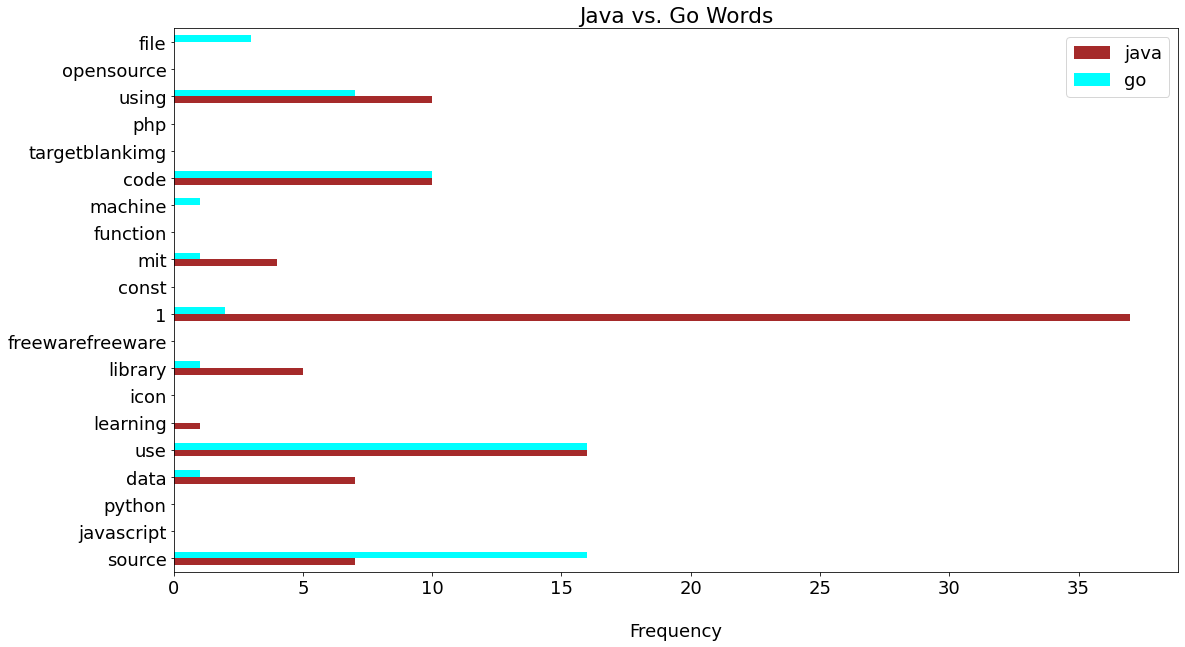

In [25]:
e.java_barh(word_counts)

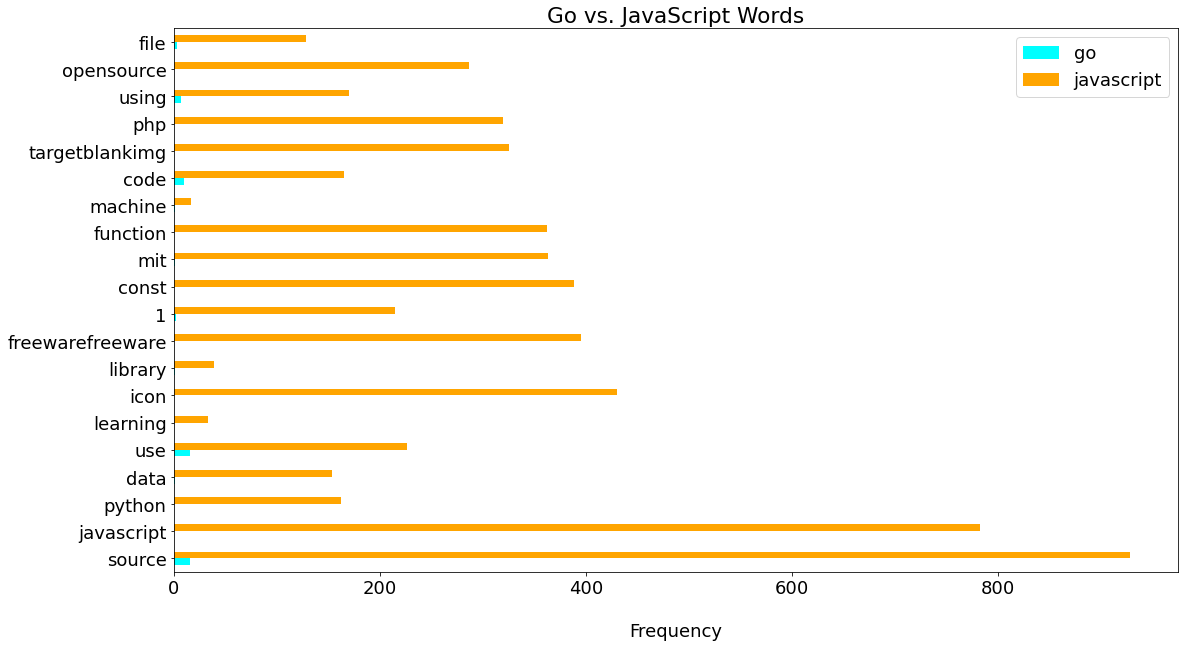

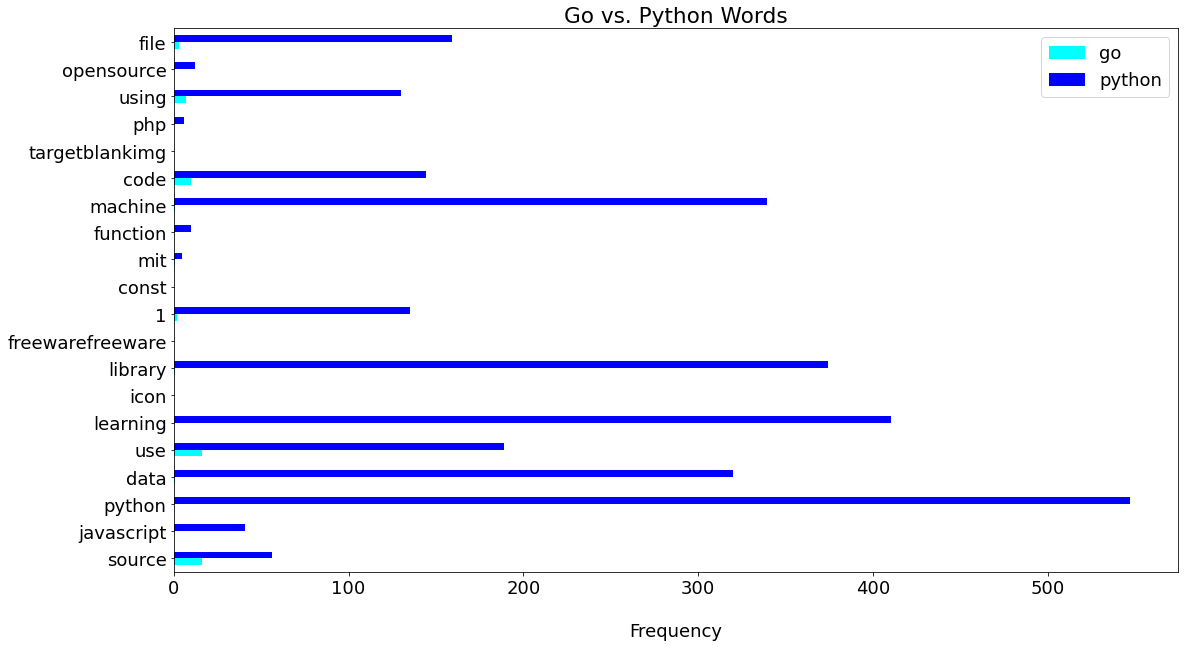

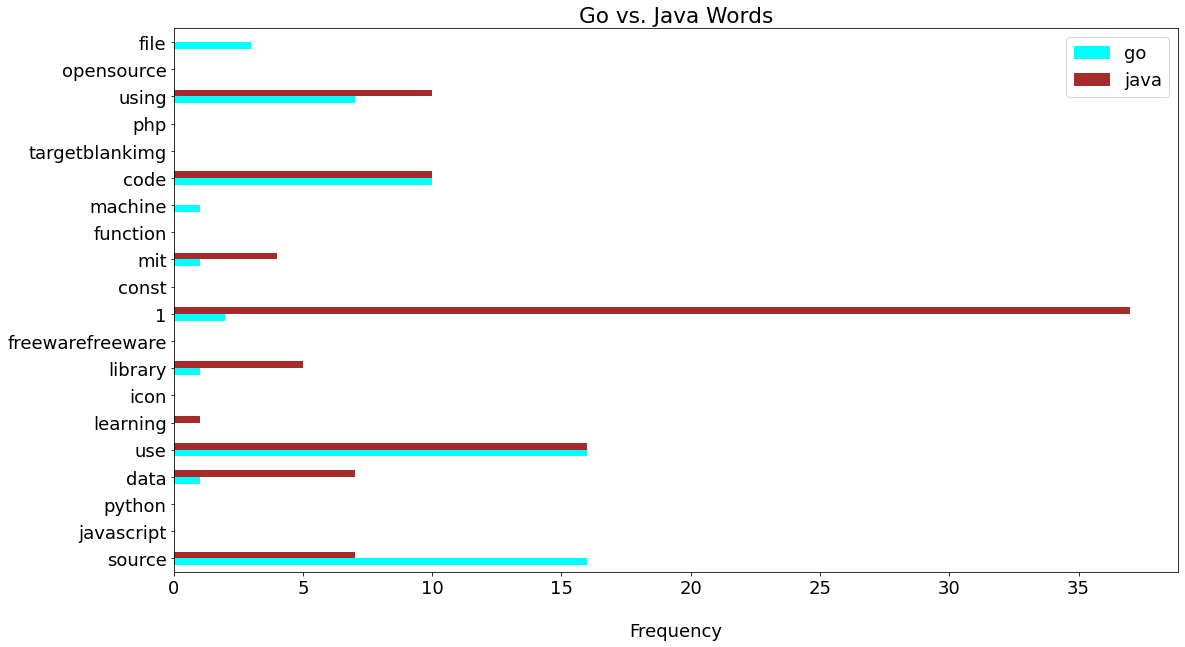

In [26]:
e.go_barh(word_counts)

#### Word Overlap Per Language

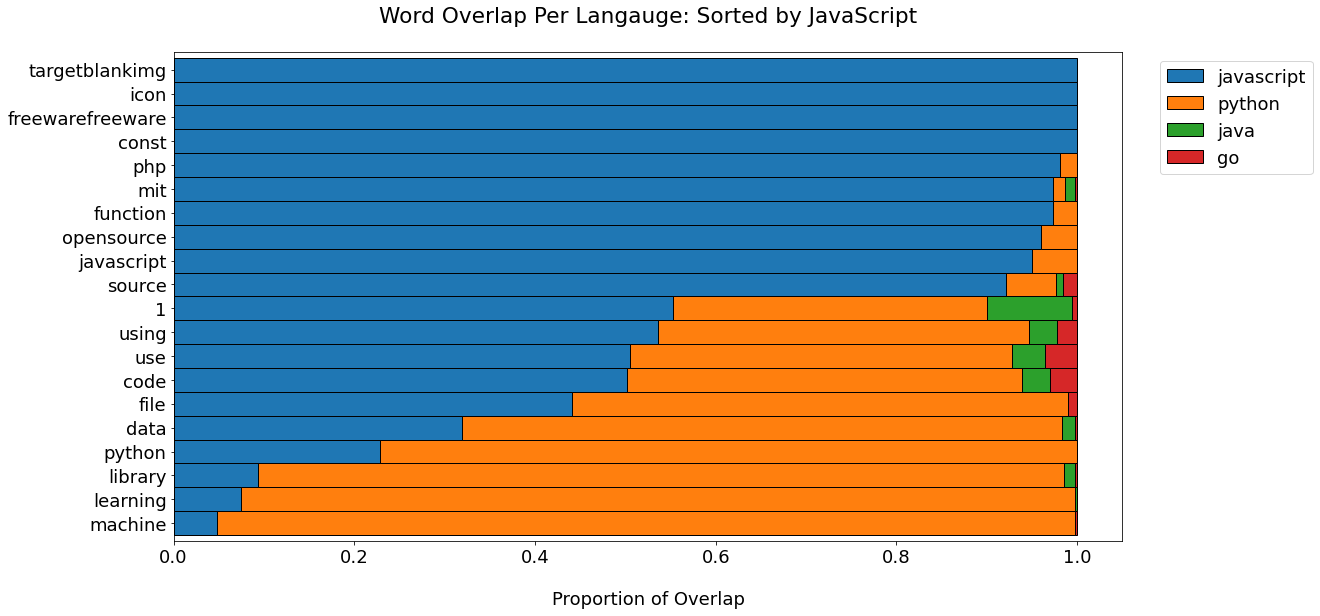

In [27]:
plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='javascript')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by JavaScript\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

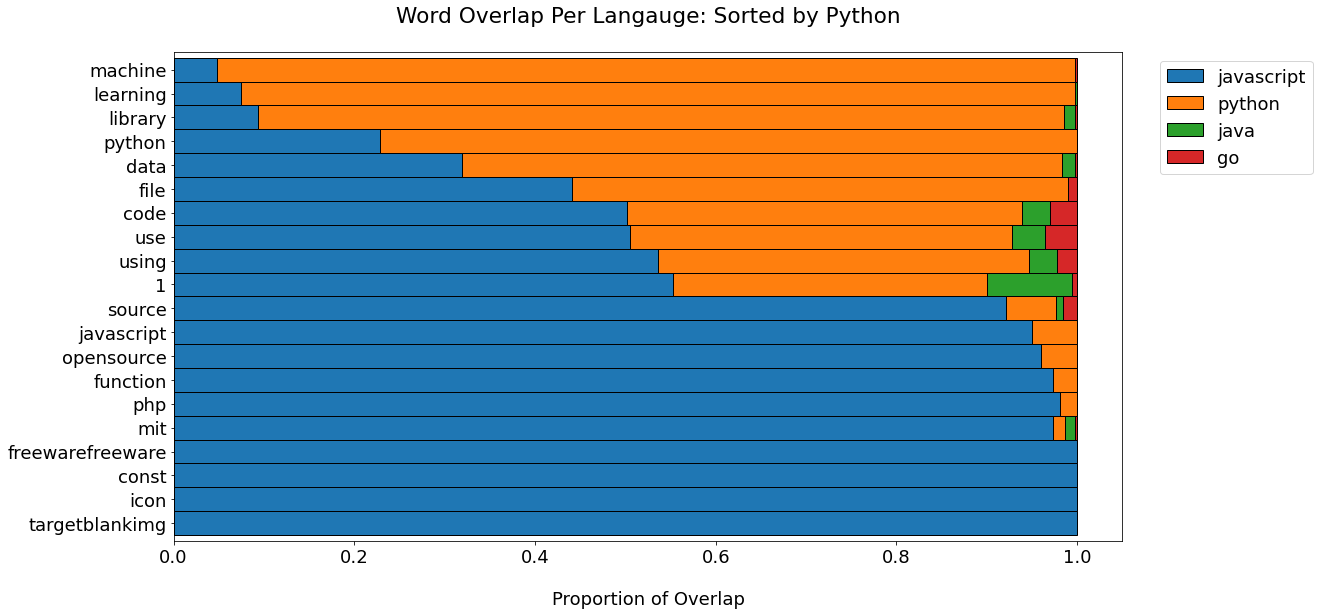

In [28]:
## proportion stacked bar charts sorted by Python

plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='python')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Python\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

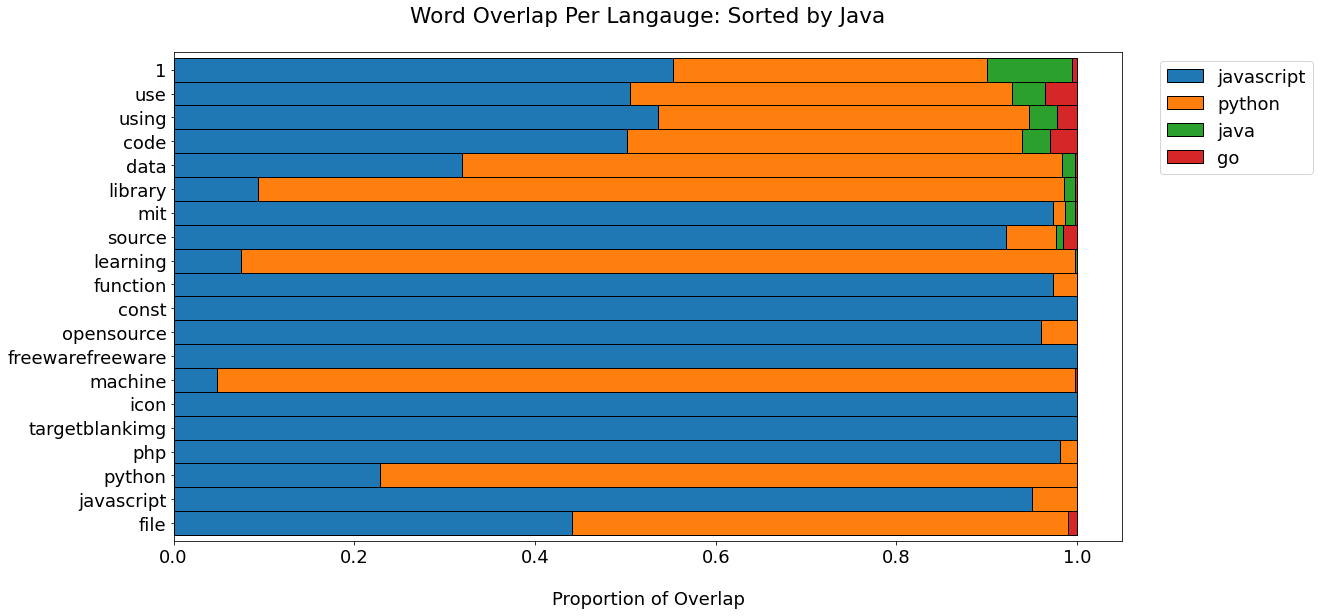

In [29]:
plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='java')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Java\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

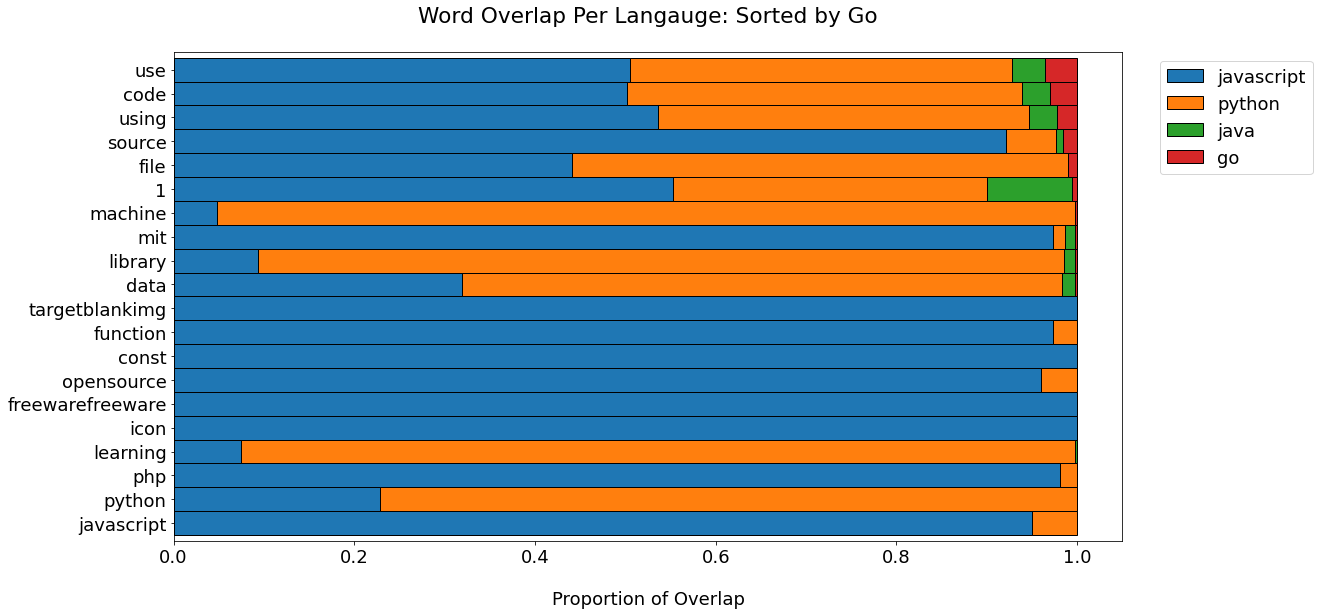

In [30]:
plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='go')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Go\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

#### Single Word Wordclouds

In [31]:
language_words = [javascript_words,python_words,java_words,go_words]

JavaScript, Python, Java, and Go Wordclouds (single words)


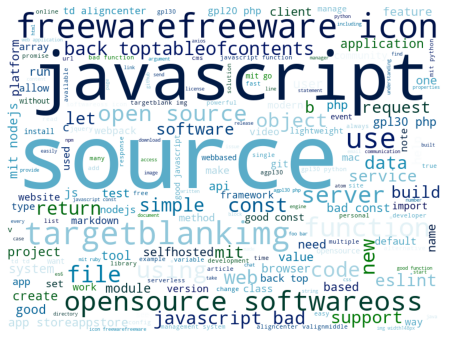

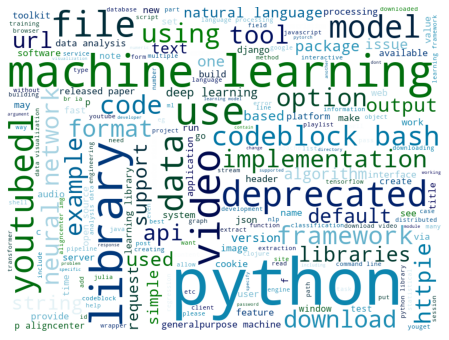

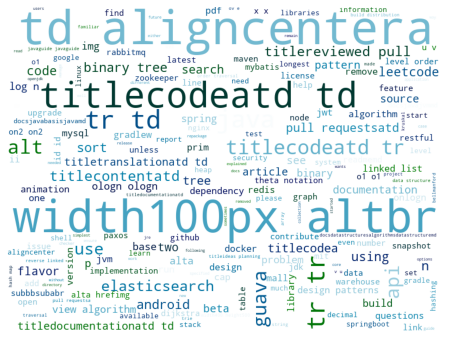

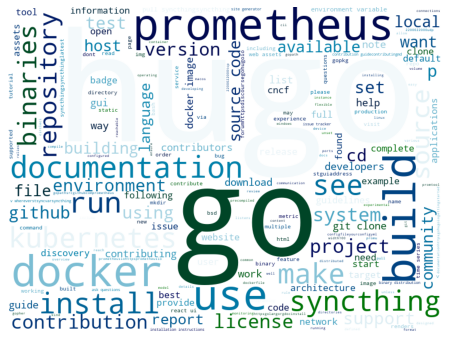

In [32]:
e.simple_wordclouds(language_words)

### Bigrams and Trigrams per Category

#### Bigrams Per Language

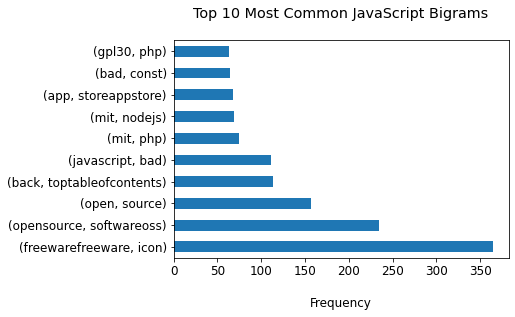

In [33]:
plt.rc('font', size=12)
pd.Series(nltk.bigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common JavaScript Bigrams\n')
plt.xlabel('\nFrequency')
None

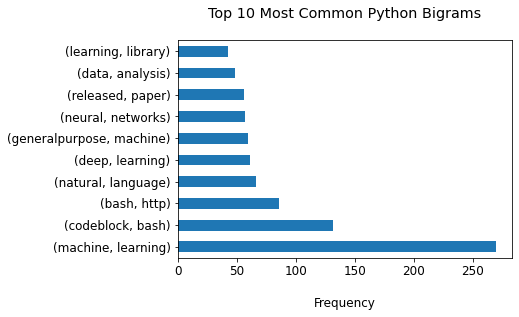

In [34]:
pd.Series(nltk.bigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Python Bigrams\n')
plt.xlabel('\nFrequency')
None

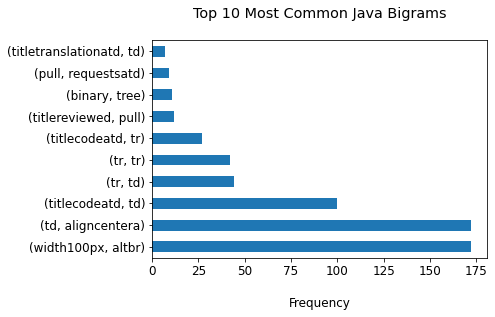

In [35]:
pd.Series(nltk.bigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Java Bigrams\n')
plt.xlabel('\nFrequency')
None

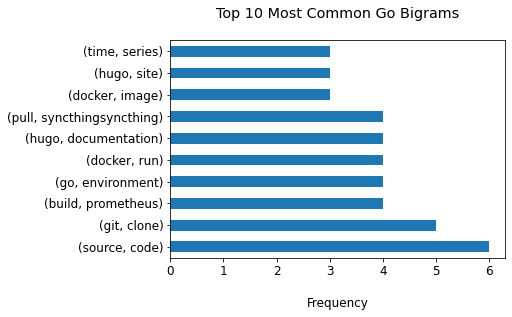

In [36]:
pd.Series(nltk.bigrams(go_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Go Bigrams\n')
plt.xlabel('\nFrequency')
None

#### All Languages Bigram

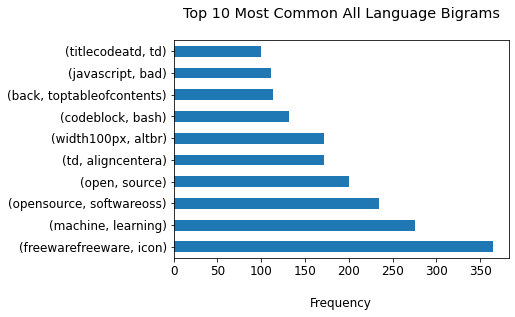

In [37]:
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common All Language Bigrams\n')
plt.xlabel('\nFrequency')
None

#### Trigrams Per Category

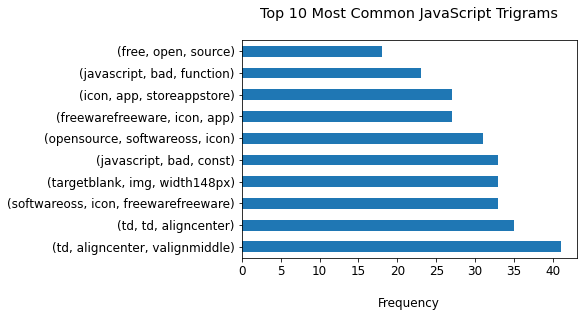

In [38]:
pd.Series(nltk.trigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common JavaScript Trigrams\n')
plt.xlabel('\nFrequency')
None

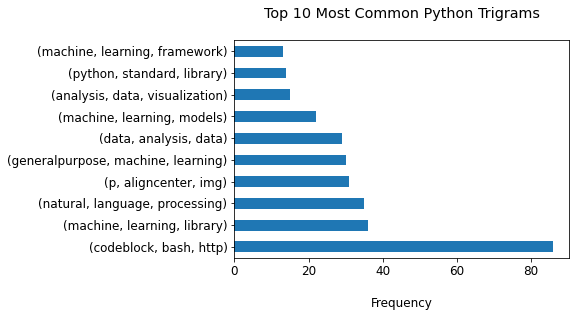

In [39]:
pd.Series(nltk.trigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Python Trigrams\n')
plt.xlabel('\nFrequency')
None

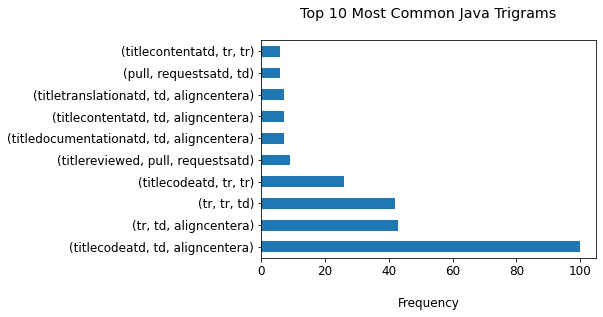

In [40]:
pd.Series(nltk.trigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Java Trigrams\n')
plt.xlabel('\nFrequency')
None

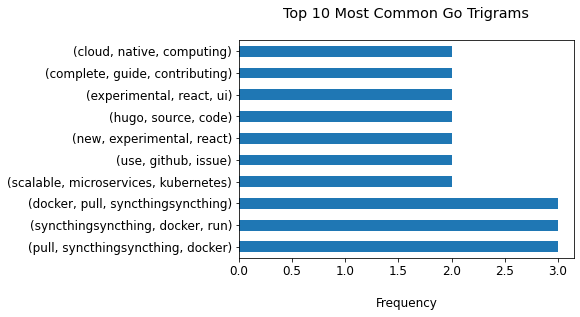

In [41]:
pd.Series(nltk.trigrams(go_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Go Trigrams\n')
plt.xlabel('\nFrequency')
None


#### All Languages Trigram

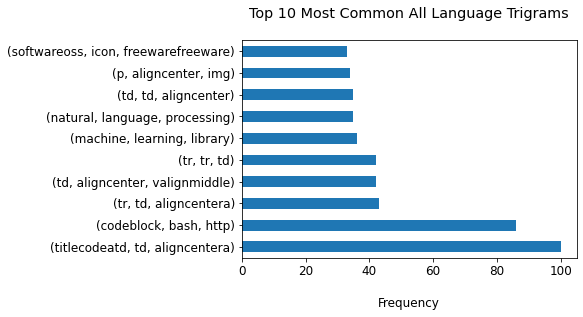

In [42]:
pd.Series(nltk.trigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common All Language Trigrams\n')
plt.xlabel('\nFrequency')
None

#### Bigram Wordclouds

In [43]:
## creating a series for the frequencies of the top 20 bigrams of all programming categories

top_20_javascript_bigrams = pd.Series(nltk.bigrams(javascript_words.split()))\
.value_counts().head(20)

top_20_python_bigrams = pd.Series(nltk.bigrams(python_words.split()))\
.value_counts().head(20)

top_20_java_bigrams = pd.Series(nltk.bigrams(java_words.split()))\
.value_counts().head(20)

top_20_go_bigrams = pd.Series(nltk.bigrams(go_words.split()))\
.value_counts().head(20)


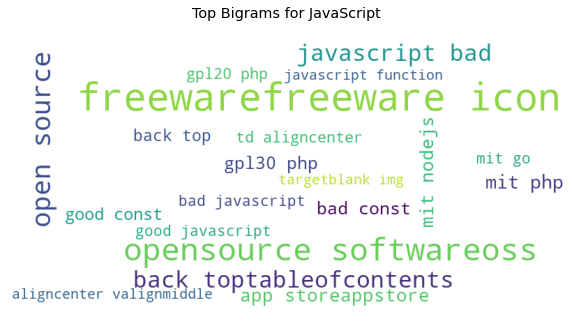

In [95]:
## using list comprehension to creat a dictionary of javascript bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Top Bigrams for JavaScript\n')
plt.axis('off')
plt.show()

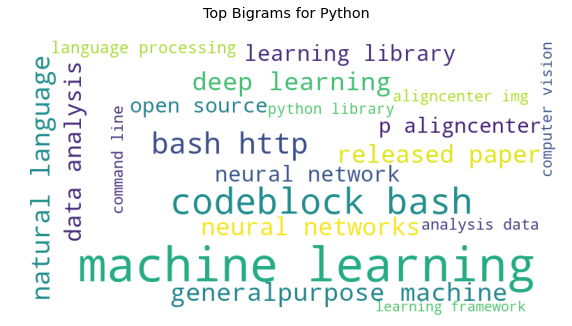

In [94]:
## using list comprehension to creat a dictionary of python bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Top Bigrams for Python\n')
plt.axis('off')
plt.show()

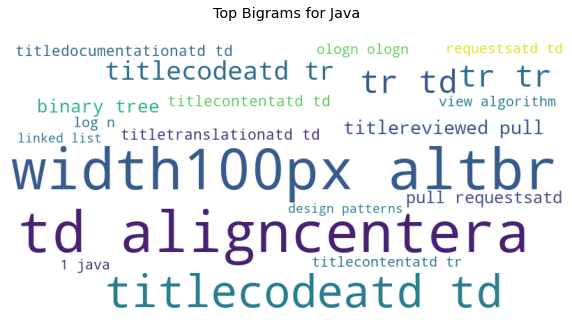

In [93]:
## using list comprehension to creat a dictionary of java bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Top Bigrams for Java\n')
plt.axis('off')
plt.show()

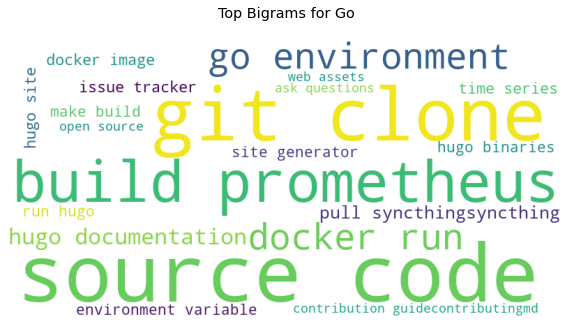

In [92]:
## using list comprehension to creat a dictionary of go bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_go_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Top Bigrams for Go\n')
plt.axis('off')
plt.show()

#### Trigram Wordclouds

In [48]:
top_20_javascript_trigrams = pd.Series(nltk.ngrams(javascript_words.split(),3))\
.value_counts().head(20)

top_20_python_trigrams = pd.Series(nltk.ngrams(python_words.split(),3))\
.value_counts().head(20)

top_20_java_trigrams = pd.Series(nltk.ngrams(java_words.split(),3))\
.value_counts().head(20)

top_20_go_trigrams = pd.Series(nltk.ngrams(go_words.split(),3))\
.value_counts().head(20)

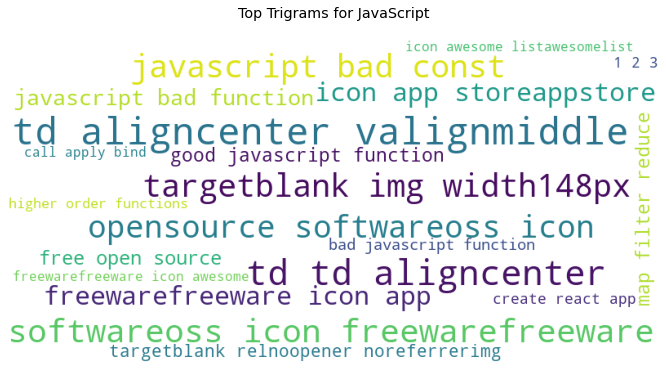

In [86]:
data = {k[0] + ' ' + k[1] + ' ' +k[2]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Trigrams for JavaScript\n')
plt.axis('off')
plt.show()

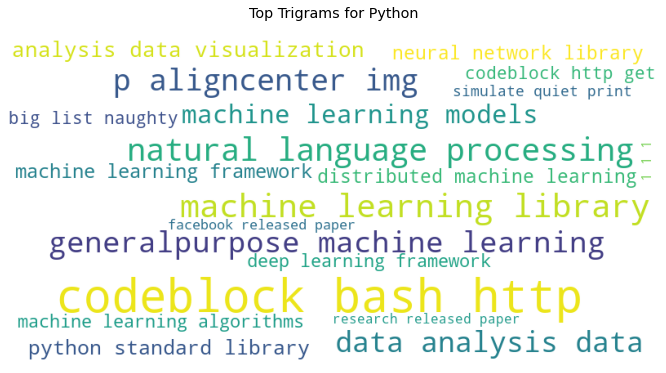

In [87]:
data = {k[0] + ' ' + k[1] + ' ' +k[2]: v for k, v in top_20_python_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Trigrams for Python\n')
plt.axis('off')
plt.show()

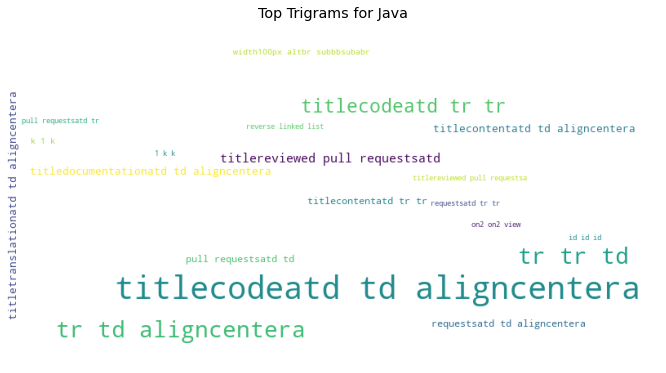

In [89]:
data = {k[0] + ' ' + k[1] + ' ' +k[2]: v for k, v in top_20_java_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Trigrams for Java\n')
plt.axis('off')
plt.show()

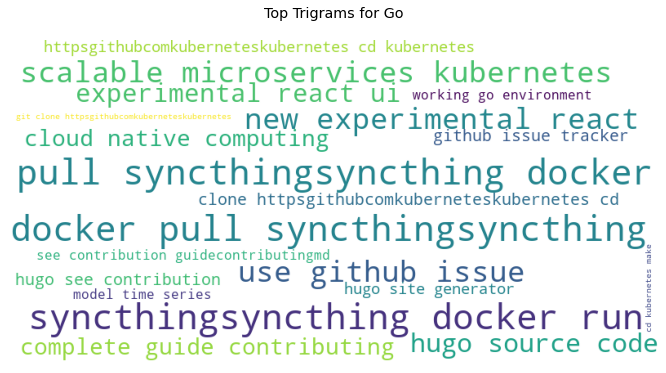

In [90]:
data = {k[0] + ' ' + k[1] + ' ' +k[2]: v for k, v in top_20_go_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title('Top Trigrams for Go\n')
plt.axis('off')
plt.show()

### Exploration Takeaways: 
 - JavaScript has the most use of the 20 most common words across all READMEs, followed up by Python.
 - Java and Go have very small proportions for the most frequent words.
 - Some of the words are not single words, but we will proceed as in the README, they were not separated by spaces.
 - Given that our data is mostly JavaScript and Python, our exploration seems reasonable. 



<a id='stats'></a>
# Statistical Testing:
---

## 2 Tailed T-Test

We will be testing for a difference of means between groups of programming languages

In [53]:
## creating categorized dataframes for each target variable value for statistical 
## testing purposes

python_df = train[train.language == 'Python'] ## creating a python df 
go_df = train[train.language == 'Go'] ## creating a go df
java_df = train[train.language == 'Java'] ## creating a Java df
javascript_df = train[train.language == 'JavaScript'] ## creating a JavaScript df

### Comparing README Lengths

In [54]:
alpha = 0.05 ## <-- Determining alpha for Readme Length Comparisons

<br>
Python Vs. JavaScript

$H_0$: There is no difference in means of Python repository character lengths and JavaScript repository character lengths

$H_a$: There is a difference in means of Python repository character lengths and JavaScript repository character lengths

In [55]:
t, p = stats.ttest_ind(python_df.readme_length,go_df.readme_length)
t, p

(1.8730261127002652, 0.07739835453118159)

<br>
Python Vs. Go

$H_0$: There is no difference in means of Python repository character lengths and Go repository character lengths

$H_a$: There is a difference in means of Python repository character lengths and Go repository character lengths

In [56]:
t, p = stats.ttest_ind(python_df.readme_length,go_df.readme_length)
t, p

(1.8730261127002652, 0.07739835453118159)

<br>
Python vs. Java

$H_0$: There is no difference in means of Python repository character lengths and Java repository character lengths

$H_a$: There is a difference in means of Python repository character lengths and Java repository character lengths

In [57]:
t, p = stats.ttest_ind(python_df.readme_length,java_df.readme_length)
t, p

(1.4402239936518584, 0.16607945065512192)

<br>

#### ReadMe Length Comparison Takeaways

 - All of the tailed t tests run on the different target variable values comparing readme character lengths returned insignifcant results.
 - All languages versus python returned p values greater than our alpha of 0.05. 
 - We fail to reject the null hypothesis
 - Therefore we can conclude that readme character length is independent of what programming language the repositories are written.

<br>

### Comparing Word Count Length

In [58]:
alpha = 0.05 ## <-- Determining alpha for Word Count Comparisons

<br>

Python vs. JavaScript

$H_0$: There is no difference in means of Python repository word counts and JavaScript repository word counts

$H_a$: There is a difference in means of Python repository word counts and JavaScript repository word counts

In [59]:
t, p = stats.ttest_ind(python_df.word_count,javascript_df.word_count)
t, p

(1.05837132519932, 0.29593549552880305)

<br>

Python vs. Go

$H_0$: There is no difference in means of Python repository word counts and Go repository word counts

$H_a$: There is a difference in means of Python repository word counts and Go repository word counts

In [60]:
t, p = stats.ttest_ind(python_df.word_count,go_df.word_count)
t, p

(1.9654645746753754, 0.06498266651964907)

<br>

Python vs. Java


$H_0$: There is no difference in means of Python repository word counts and Java repository word counts

$H_a$: There is a difference in means of Python repository word counts and Java repository word counts

In [61]:
t, p = stats.ttest_ind(python_df.word_count,java_df.word_count)
t, p

(1.837911764774864, 0.08176427090150006)

<br>

#### Word Count Comparison Takeaways

 - All of the tailed t tests run on the different target variable values comparing word count returned insignifcant results
 - All languages versus python returned p values greater than our alpha of 0.05 
 - We fail to reject the null hypothesis
 - Therefore we can conclude the word count of the readme is independent of what programming language the repositories are written.

<a id='modeling'></a>
# Modeling
---

We are going to use classification models in order to predict the programming language. 
We will use decision tree, random forest, logistic regression, KNN, and a Naive Bayes and emphasize on accuracy.


The first step is to initiaize the TfidfVectorizer, and split our data into X and y sets.

In [62]:
#intialize TfidfVectorizer, use single words, bigrams and trigrams
tfidf = TfidfVectorizer(ngram_range=(1,3))
X = tfidf.fit_transform(df.clean)
y = df.language

#split the data into X_train, X_validate, X_test, y_train, y_validate, y_test
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, random_state=12, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=.2, random_state=12, stratify= y_train_validate)

In [63]:
#view some of the feature names being used 
pprint(df.clean)
pd.DataFrame(X.todense(), columns=tfidf.get_feature_names())

0      freecodecamporg social bannerhttpss3amazonawsc...
1      p aligncentera hrefhttpsvuejsorg targetblank r...
2      reacthttpsreactjsorg middot github licensehttp...
3      p aligncenter hrefhttpsgetbootstrapcom img src...
4      public apis run testshttpsgithubcompublicapisp...
                             ...                        
102    img srchttpsgithubcomgogsgogsrawmainpublicimgf...
103    p aligncenterimg aligncenter stylewidth320px s...
104    iptv autoupdatehttpsgithubcomiptvorgiptvaction...
105    mermaid build statushttpstravisciorgmermaidjsm...
106    readmereadme br languagehttpsgithubcomkon9chun...
Name: clean, Length: 107, dtype: object


,000,000 ten,000 ten classic,00008080,00008080 routerrun8080,00008080 routerrun8080 sample,00008080 routerrun8080 serving,00008080 rrun8080,00008080 rrun8080 client,00008080 rrun8080 custom,...,zynga engineering,zynga engineering bloghttpswwwzyngacomblogsengineering,zyszyshttpsgithubcomzyszys,zyszyshttpsgithubcomzyszys yongsheng,zyszyshttpsgithubcomzyszys yongsheng zhang,zyte,zyte formerly,zyte formerly scrapinghub,zyte httpswwwzytecom,zyte httpswwwzytecom check
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We should to establish a baseline. Let's see what the most common programming language is in our y_train.

In [64]:
#use most common programming language as baseline
y_train.value_counts()

JavaScript    35
Python        15
Java          10
Go             8
Name: language, dtype: int64

Our baseline model will assume that every repository's most used language is JavaScript

In [65]:
#establish the baseline
train['baseline_prediction'] = 'JavaScript'
baseline_score = round(accuracy_score(train.language, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.53


Now we will create a train and test dataframe, we will be able to add our predictions to it to evaluate how the models perform

In [66]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

<br>
<br>

### Decision Tree

In [67]:
#decision tree fit to X and y train
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

#prediction columns 
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

#train and validate scores to check for overfitness 
print(f'train score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')

train score: 79.41%
validate score: 64.71%


In [68]:
#accuracy on train, confusion matrix, and classification report for decision tree
m.model_info(train)

Accuracy: 79.41%
---
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
Java         0     6           0       0
JavaScript   8     3          35       2
Python       0     1           0      13
---
              precision    recall  f1-score   support

          Go       0.00      0.00      0.00         8
        Java       1.00      0.60      0.75        10
  JavaScript       0.73      1.00      0.84        35
      Python       0.93      0.87      0.90        15

    accuracy                           0.79        68
   macro avg       0.66      0.62      0.62        68
weighted avg       0.73      0.79      0.74        68



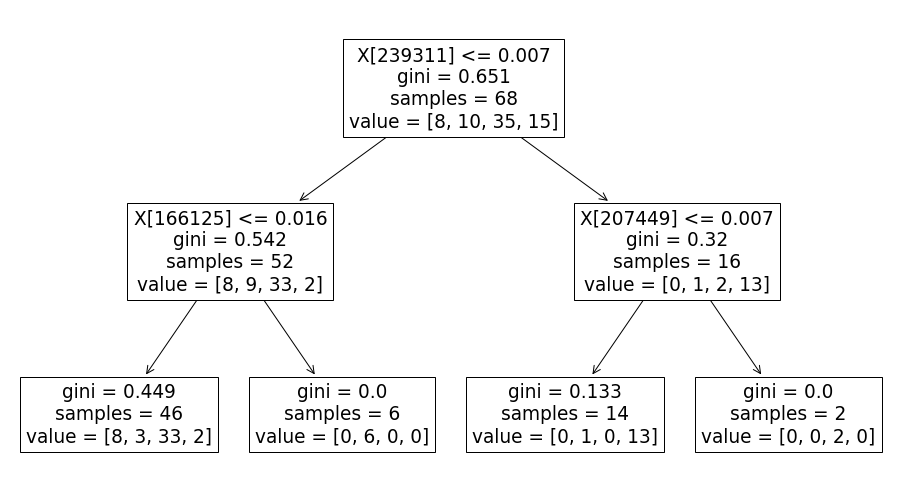

In [69]:
#visualize our decision tree
plt.figure(figsize=(16,9))
plot_tree(tree)
plt.show()

In [70]:
#decision tree scores
tree_accuracy = round(sklearn.metrics.accuracy_score(y_train, train.predicted),2)
tree_precision = round(sklearn.metrics.precision_score(y_train, train.predicted, average='macro'),2)
tree_recall = round(sklearn.metrics.recall_score(y_train, train.predicted, average='macro'),2)
print('Scores for Decision Tree!')
print('---------------------------')
print(f'Our baseline score is {baseline_score}')
print(f'Accuracy score is {tree_accuracy}')
print(f'Precision score is {tree_precision}')
print(f'Recall score is {tree_recall}')

Scores for Decision Tree!
---------------------------
Our baseline score is 0.53
Accuracy score is 0.79
Precision score is 0.66
Recall score is 0.62


<br>
Our decision tree model seems a bit overfit on the training set, this may mean it will perform poorly on out of sample data. 
It does perform better than our baseline though.

<br>

### Random Forest

In [71]:
#random forest fit to our X and y train
rf = RandomForestClassifier(random_state=906, max_depth = 2).fit(X_train, y_train)

#prediction columns
train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

#check for overfitness
print(f'train score: {rf.score(X_train, y_train):.2%}')
print(f'validate score: {rf.score(X_validate, y_validate):.2%}')

train score: 51.47%
validate score: 52.94%


In [72]:
#accuracy on train, confusion matrix, and classification report for random forest
m.model_info(train)

Accuracy: 51.47%
---
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
JavaScript   8    10          35      15
---
              precision    recall  f1-score   support

          Go       0.00      0.00      0.00         8
        Java       0.00      0.00      0.00        10
  JavaScript       0.51      1.00      0.68        35
      Python       0.00      0.00      0.00        15

    accuracy                           0.51        68
   macro avg       0.13      0.25      0.17        68
weighted avg       0.26      0.51      0.35        68



In [73]:
#random forest scores
rf_accuracy = round(sklearn.metrics.accuracy_score(y_train, train.predicted),2)
rf_precision = round(sklearn.metrics.precision_score(y_train, train.predicted, average='macro'),2)
rf_recall = round(sklearn.metrics.recall_score(y_train, train.predicted, average='macro'),2)
print('Scores for Random Forest!')
print('---------------------------')
print(f'Our baseline score is {baseline_score}')
print(f'Accuracy score is {rf_accuracy}')
print(f'Precision score is {rf_precision}')
print(f'Recall score is {rf_recall}')

Scores for Random Forest!
---------------------------
Our baseline score is 0.53
Accuracy score is 0.51
Precision score is 0.13
Recall score is 0.25


<br>
The random forest model does not predict for Python, Java, or Go. It actually predicts that every repository is JavaScript. It does not beat the baseline.

<br>

### Logistic Regression

In [74]:
#fit logistic regression to our X and y train
lm = LogisticRegression(C=.6).fit(X_train, y_train)

#prediction columns
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

#check for overfitness
print(f'train score: {lm.score(X_train, y_train):.2%}')
print(f'validate score: {lm.score(X_validate, y_validate):.2%}')

train score: 52.94%
validate score: 52.94%


In [75]:
#accuracy on train, confusion matrix, and classification report for logistic regression
m.model_info(train)

Accuracy: 52.94%
---
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
JavaScript   8    10          35      14
Python       0     0           0       1
---
              precision    recall  f1-score   support

          Go       0.00      0.00      0.00         8
        Java       0.00      0.00      0.00        10
  JavaScript       0.52      1.00      0.69        35
      Python       1.00      0.07      0.12        15

    accuracy                           0.53        68
   macro avg       0.38      0.27      0.20        68
weighted avg       0.49      0.53      0.38        68



In [76]:
#logistic regression scores
logit_accuracy = round(sklearn.metrics.accuracy_score(y_train, train.predicted),2)
logit_precision = round(sklearn.metrics.precision_score(y_train, train.predicted, average='macro'),2)
logit_recall = round(sklearn.metrics.recall_score(y_train, train.predicted, average='macro'),2)
print('Scores for Logistic Regression!')
print('---------------------------')
print(f'Our baseline score is {baseline_score}')
print(f'Accuracy score is {logit_accuracy}')
print(f'Precision score is {logit_precision}')
print(f'Recall score is {logit_recall}')

Scores for Logistic Regression!
---------------------------
Our baseline score is 0.53
Accuracy score is 0.53
Precision score is 0.38
Recall score is 0.27


<br>
Logistic Regression only makes JavaScript and Python predictions (but it assumed everything was JavaScript except for one single Python one)

Tied with the baseline. 

<br>

### KNN

In [77]:
#use 9 for n_neighbors for single words
#use 10 for n_neighbors bigrams and trigrams

#fit KNN to our X and y train
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

#prediction columns
train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

#check for overfitness
print(f'train score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

train score: 86.76%
validate score: 82.35%


In [78]:
#accuracy on train, confusion matrix, and classification report for KNN
m.model_info(train)

Accuracy: 86.76%
---
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
Go           7     0           0       0
Java         0     6           1       1
JavaScript   1     3          33       1
Python       0     1           1      13
---
              precision    recall  f1-score   support

          Go       1.00      0.88      0.93         8
        Java       0.75      0.60      0.67        10
  JavaScript       0.87      0.94      0.90        35
      Python       0.87      0.87      0.87        15

    accuracy                           0.87        68
   macro avg       0.87      0.82      0.84        68
weighted avg       0.87      0.87      0.86        68



In [79]:
#knn scores
knn_accuracy = round(sklearn.metrics.accuracy_score(y_train, train.predicted),2)
knn_precision = round(sklearn.metrics.precision_score(y_train, train.predicted, average='macro'),2)
knn_recall = round(sklearn.metrics.recall_score(y_train, train.predicted, average='macro'),2)
print('Scores for KNN!')
print('---------------------------')
print(f'Our baseline score is {baseline_score}')
print(f'Accuracy score is {knn_accuracy}')
print(f'Precision score is {knn_precision}')
print(f'Recall score is {knn_recall}')

Scores for KNN!
---------------------------
Our baseline score is 0.53
Accuracy score is 0.87
Precision score is 0.87
Recall score is 0.82


Our KNN model beats the baseline, and does well at accurately predicting the repository's most used programming language.

<br>

### Naive Bayes

In [80]:
#we're using a multinomial naive bayes fit to our X and y train
nb = MultinomialNB(alpha=1.4).fit(X_train, y_train)

#prediction columns
train['predicted'] = nb.predict(X_train)
test['predicted'] = nb.predict(X_test)

#check for overfitness
print(f'train score: {nb.score(X_train, y_train):.2%}')
print(f'validate score: {nb.score(X_validate, y_validate):.2%}')

train score: 52.94%
validate score: 52.94%


In [81]:
#accuracy on train, confusion matrix, and classification report for naive bayes
m.model_info(train)

Accuracy: 52.94%
---
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
JavaScript   8    10          35      14
Python       0     0           0       1
---
              precision    recall  f1-score   support

          Go       0.00      0.00      0.00         8
        Java       0.00      0.00      0.00        10
  JavaScript       0.52      1.00      0.69        35
      Python       1.00      0.07      0.12        15

    accuracy                           0.53        68
   macro avg       0.38      0.27      0.20        68
weighted avg       0.49      0.53      0.38        68



In [82]:
#naive bayes scores
nb_accuracy = round(sklearn.metrics.accuracy_score(y_train, train.predicted),2)
nb_precision = round(sklearn.metrics.precision_score(y_train, train.predicted, average='macro'),2)
nb_recall = round(sklearn.metrics.recall_score(y_train, train.predicted, average='macro'),2)
print('Scores for Naive Bayes!')
print('---------------------------')
print(f'Our baseline score is {baseline_score}')
print(f'Accuracy score is {nb_accuracy}')
print(f'Precision score is {nb_precision}')
print(f'Recall score is {nb_recall}')

Scores for Naive Bayes!
---------------------------
Our baseline score is 0.53
Accuracy score is 0.53
Precision score is 0.38
Recall score is 0.27


<br>
Multinomial Naive Bayes actually performs the exact same as our logistic regression. It predicted that every repository was JavaScript except for 1 which was predicted as Python. It is tied with our baseline.

<br>

### Modeling Takeaways: 
 - Random Forest, Logistic Regression, Naive Bayes do not predict Java or Go languages. Can probably be fixed with more data, and adjustment of hyperparameters
 - KNN performs the best at ~87% accuracy on train. 

<a id='test'></a>
# Test
---

Our best performing model: KNN

Let's get a recap on how it did!

In [83]:
#bringing back our KNN model from above, just refreshing on its train and validate scores
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

print(f'train score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

train score: 86.76%
validate score: 82.35%


<br>
Let's put it to the test!

In [84]:
#get accuracy score for test set predictions vs. test set actual results
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('------------------------------------------------------')

#print the confusion matrix for test set predictions vs test set actual results
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('------------------------------------------------------')

#print classification report 
print(classification_report(test.actual, test.predicted))
print('------------------------------------------------------')

#train, validate, and test scores for KNN
print(f'Our baseline score is {baseline_score*100}%')
print(f'Training score: {knn.score(X_train, y_train):.2%}')
print(f'Validate score: {knn.score(X_validate, y_validate):.2%}')
print(f'Test score: {knn.score(X_test, y_test):.2%}')

Accuracy: 81.82%
------------------------------------------------------
Confusion Matrix
actual      Go  Java  JavaScript  Python
predicted                               
Go           1     0           1       0
Java         0     3           0       0
JavaScript   2     0          10       1
Python       0     0           0       4
------------------------------------------------------
              precision    recall  f1-score   support

          Go       0.50      0.33      0.40         3
        Java       1.00      1.00      1.00         3
  JavaScript       0.77      0.91      0.83        11
      Python       1.00      0.80      0.89         5

    accuracy                           0.82        22
   macro avg       0.82      0.76      0.78        22
weighted avg       0.82      0.82      0.81        22

------------------------------------------------------
Our baseline score is 53.0%
Training score: 86.76%
Validate score: 82.35%
Test score: 81.82%


In [85]:
knn_accuracy = round(sklearn.metrics.accuracy_score(y_test, test.predicted),2)
knn_precision = round(sklearn.metrics.precision_score(y_test, test.predicted, average='macro'),2)
knn_recall = round(sklearn.metrics.recall_score(y_test, test.predicted, average='macro'),2)

print(f'KNN accuracy score is {knn_accuracy}')
print(f'KNN precision score is {knn_precision}')
print(f'KNN recall score is {knn_recall}')

KNN accuracy score is 0.82
KNN precision score is 0.82
KNN recall score is 0.76


<a id='conclusion'></a>
# Conclusion and Next Steps
---

 - Using a combination of single words, bigrams, and trigrams, our best performing model was a KNN. 
 - It beat the baseline by 28.82%. 
 - Accuracy of 82%, precision of 82%, and recall of 76%

With more time, we would like to use more repositories to potentially find more words that can help predict the programming language used. We'd also take more time to prepare our data to assure we are using meaningful readmes.